In [2]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import math
import seaborn as sns

from pylab import *
from scipy.integrate import *
from scipy.special import zeta
from kuramoto import Kuramoto, plot_phase_coherence, plot_activity



## Q1. Simular o modelo de Kuramoto em redes geradas pelos modelos de Erdős–Rényi, Barabási–Albert e Watts–Strogatz. Em um mesmo gráfico, plotar a curva do parâmetro de ordem r em função do acoplamento lambda para cada rede. Analisar qual tipo de rede sincroniza com maior facilidade. Indicar também o valor teórico do acoplamento crítico.

In [5]:
# First-order Kuramoto model
def F(Y,t, G, W, lbd):
    #global W, N, lbd, G
    N = len(G.nodes())
    F = zeros((N),float)
    S = zeros((N),float)
    dg = G.degree()
    for i in range(0,N):
        for j in G.neighbors(i):
            S[i] = S[i] + sin(Y[j]-Y[i]) #
    ld = lbd
    F = W + ld*S #traditional Kuramoto
    return F

In [52]:
def kuramotoModel(G):
    N = len(G) # Number of nodes
    vk = dict(G.degree())
    vk = list(vk.values())
    av_k = mean(vk)
    
    from numpy import linalg as LA
    A = nx.adjacency_matrix(G)
    A = A.todense()
    eig = LA.eigvalsh(A)
    lambda_max = eig.max()
    
    if lambda_max <= 0:
        print("Cuidado: lambda_max inválido!")
        lambda_max = 1e-6 
    
    # Initial phases
    w0 = np.pi
    y0 = np.random.normal(0, w0, size = N)
    
    
    # Natural frequencies
    W = np.random.uniform(-w0, w0, size = N)
    #W = np.random.normal(0, w0, size = N)
    
    # Critical couping %%%%%%%%%%%%%%%%
    hist, bin_edges = np.histogram(W, density=True)
    g0 = max(hist)
    lambda_c = 2/(np.pi*lambda_max*g0)
    print('Critical coupling:', lambda_c)
    
    # time of integration
    t0 = 0.0  # Start of integration 
    h = 0.02 # Step size
    Np = 3000 # number of steps
    tStop = int(Np*h) # end of integration
    t = linspace(t0,tStop,Np)
    
    #forward sync
    vlbd = []  # vector that stores the coupling strength
    aux = 0
    Ns = 1 #Number of simulations
    vlbd = np.arange(0, 10*lambda_c, lambda_c/5) #variation of the coupling strength
    mvr = np.zeros(shape=shape(vlbd))
    for s in arange(0,Ns):
        vr = []  # vector that stores the order parameter
        for lbd in vlbd:
            y = odeint(F, y0, t, (G, W, lbd))
            y = np.array(y)
            y = y[range(len(y)-round(0.9*len(y)),len(y)),:]
            y = y.mean(0)
            psi = mean(y)
            r = abs((1.0/N)*sum(np.exp(1j*y)))
            vr.append(r)
            aux = aux + 1
            #print(aux, ": ", lbd, r)
            y0 = y # adiabatic increase
        mvr = mvr + vr
    mvr = mvr/Ns
    vlbd = array(vlbd, dtype=float)

    return(mvr, vlbd, lambda_c, lambda_max)

In [42]:
def convertGraph(G):
    G = G.to_undirected()
    Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
    G = G.subgraph(Gcc[0])
    G = nx.convert_node_labels_to_integers(G, first_label=0)
    G = nx.convert_node_labels_to_integers(G, first_label=0)
    return (G)

In [19]:
# Network parameters
N = 100 #number of nodes
av_degree = 10 # average degree
p = float(av_degree)/float(N) #probability of connection in the ER model
m = int(av_degree/2) # number of nodes included at each time step in the BA model
kappa = av_degree # number of neighbors in the WS model

In [21]:
# generate a BA network
Gba = nx.barabasi_albert_graph(N,m)
Gba = convertGraph(Gba)

In [29]:
# generate ER network
Ger = nx.gnp_random_graph(N, p, seed=None, directed=False)
Ger = convertGraph(Ger)

In [27]:
# generate WS network
Gws = nx.watts_strogatz_graph(N, kappa, p, seed=None)
Gws = convertGraph(Gws)

In [31]:
mvr_ba, vlbd_ba, lambda_c_ba, _ = kuramotoModel(Gba)
mvr_er, vlbd_er, lambda_c_er, _ = kuramotoModel(Ger)
mvr_ws, vlbd_ws, lambda_c_ws, _ = kuramotoModel(Gws)

Critical coupling: 0.19431445724951854
Critical coupling: 0.2180931353032161
Critical coupling: 0.28124569040733904


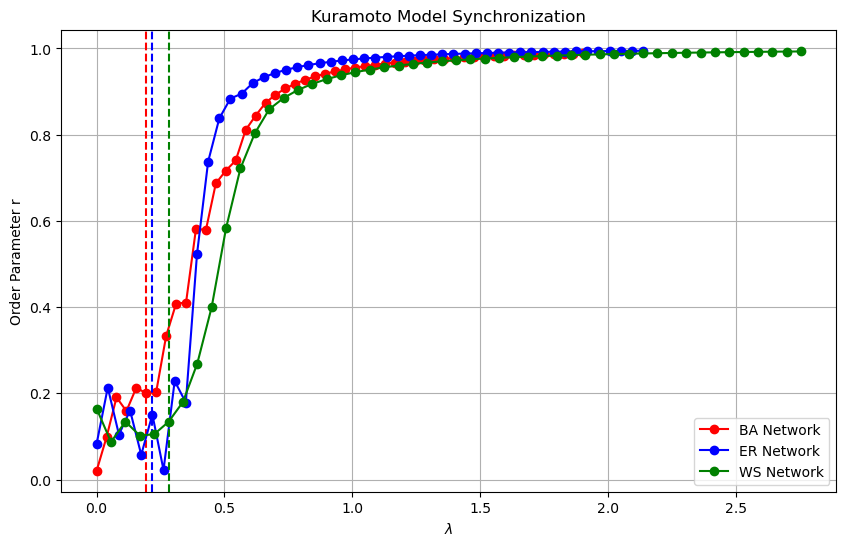

In [32]:
# Plot
plt.figure(figsize=(10,6))

plt.plot(vlbd_ba, mvr_ba, '-o', color='red', label='BA Network')
plt.axvline(x=lambda_c_ba, color='red', linestyle='--')

plt.plot(vlbd_er, mvr_er, '-o', color='blue', label='ER Network')
plt.axvline(x=lambda_c_er, color='blue', linestyle='--')

plt.plot(vlbd_ws, mvr_ws, '-o', color='green', label='WS Network')
plt.axvline(x=lambda_c_ws, color='green', linestyle='--')

plt.xlabel(r'$\lambda$')
plt.ylabel('Order Parameter r')
plt.title('Kuramoto Model Synchronization')
plt.legend()
plt.grid(True)
plt.show()

Nota-se a partir do gráfico que a rede que sincorniza com a maior facilidade é a de Barabási–Albert, possuindo o menor Critical coupling strength entre as 3 redes

## Q2.  No modelo de Watts–Strogatz, investigar como a sincronização depende do parâmetro p (probabilidade de reconexão). Em um único gráfico, plotar a curva do parâmetro de ordem r em função do acoplamento lambda para diferentes valores de p (por exemplo:  =0.0, 0.0001; 0.001, 0.01, 0.1, 0.5). Avaliar se a rede sincroniza mais facilmente à medida que p aumenta.



Critical coupling: 0.3029514232031671
p=0.0, mvr=[0.21596314 0.1409427  0.05304245 0.12544771 0.32556531 0.18647646
 0.17789512 0.23301374 0.36203586 0.21531915 0.62569415 0.82043921
 0.41157334 0.15907609 0.60845844 0.38977142 0.4558059  0.52015805
 0.57340803 0.61794402 0.65568341 0.6879998  0.71591451 0.74020866
 0.76149198 0.78024809 0.79686552 0.81165991 0.82489006 0.83677006
 0.8474783  0.85716453 0.86595506 0.87395733 0.88126312 0.88795099
 0.89408893 0.8997356  0.9049422  0.90975332 0.91420806 0.91834079
 0.92218184 0.92575806 0.92909322 0.93220856 0.93512297 0.93785336
 0.94041492 0.94282131 0.94508479]
Critical coupling: 0.23401971997464663
p=0.0001, mvr=[0.10208934 0.05926867 0.11573532 0.17811793 0.21367195 0.04900805
 0.18133386 0.09783729 0.13741862 0.30571218 0.3725745  0.33416252
 0.69431517 0.72662416 0.72667931 0.82054644 0.43331976 0.32229835
 0.46146678 0.59973409 0.84521487 0.56042003 0.79279145 0.35837903
 0.31058768 0.25984366 0.23395956 0.23091715 0.24497137 0.2

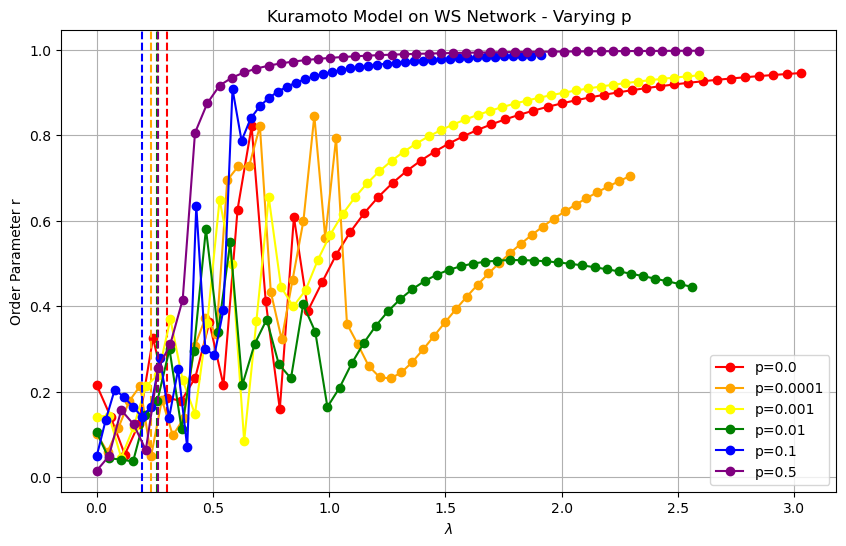

In [54]:
pVector = [0.0, 0.0001, 0.001, 0.01, 0.1, 0.5]

colors = ['red', 'orange', 'yellow', 'green', 'blue', 'purple']

plt.figure(figsize=(10,6))

for x, color in zip(pVector, colors):
    Gws = nx.watts_strogatz_graph(N, kappa, x, seed=None)
    Gws = convertGraph(Gws) 

    mvr_ws, vlbd_ws, lambda_c_ws, _ = kuramotoModel(Gws)

    plt.plot(vlbd_ws, mvr_ws, '-o', color=color, label=f'p={x}')
    plt.axvline(x=lambda_c_ws, color=color, linestyle='--')
    print(f'p={x}, mvr={mvr_ws}')


plt.xlabel(r'$\lambda$')
plt.ylabel('Order Parameter r')
plt.title('Kuramoto Model on WS Network - Varying p')
plt.legend()
plt.grid(True)
plt.show()

Nota-se a partir do gráfico que a variação do parâmetro p (probabilidade de reconexão) é influente na sincronização da rede do modelo WS, no qual aumentando o parâmtro para 0.1 ou 0.5 a rede teve uma sincronização. Portanto, é visível que é preciso um valor relevante de p para obter uma sincronização completa